# A rotating mesh with spots

In [1]:
from spice.models import IcosphereModel
from spice.models.mesh_transform import add_rotation, evaluate_rotation
from spice.plots import plot_3D, plot_3D_mesh_and_spectrum
from spice.spectrum import simulate_observed_flux
import astropy.units as u
import jax.numpy as jnp
import numpy as np
from transformer_payne import Blackbody
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import cmasher as cmr

Let's use the simplest example for the sake of speed - the blackbody flux from the ```transformer_payne``` package.

In [2]:
bb = Blackbody()

The API is in the functional paradigm - you pass a "model" mesh, and the function returns a modified version of the mesh. However, the original passed mesh still remains if you choose not to overwrite these variables.

You can add a spot as a circular spot with defined coordinates. Spots can also be added as spherical harmonic functions.

In [3]:
from spice.models.spots import add_spot

base_temp = 5700
spot_temp = 15000

m = IcosphereModel.construct(1000, 1., 1., bb.to_parameters(dict(teff=base_temp)), bb.parameter_names)

m = add_spot(mesh=m, spot_center_theta=1.5, spot_center_phi=1.5, spot_radius=50., parameter_delta=spot_temp - base_temp, parameter_index=0, smoothness=0.5)

/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:231: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(
/Users/mjablons/anaconda3/envs/astro/lib/python3.11/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


The API is in the functional paradigm - you pass a "model" mesh, and the function returns a modified version of the mesh. However, the original passed mesh still remains if you choose not to overwrite these variables.

Let's call the ```evaluate``` function to include rotation and calculate models with rotation effects for various rotation phases.

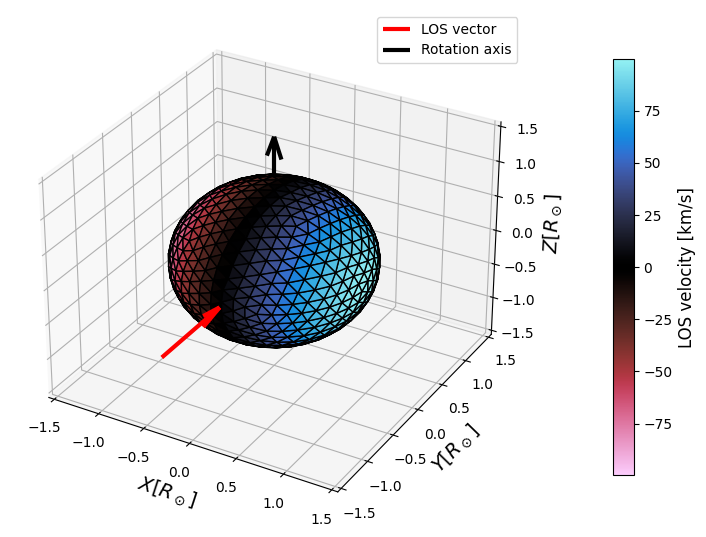

In [4]:
# Calculate rotation period from v_rot and radius
v_rot = 100  # km/s
r_sun = 696340  # km
circumference = 2 * np.pi * r_sun
period_seconds = circumference / v_rot  # Convert v_rot to m/s

TIMESTAMPS = np.linspace(0, period_seconds, 100)

mt = add_rotation(m, v_rot, jnp.array([0., 0., 1.]))
mts = [evaluate_rotation(mt, t) for t in TIMESTAMPS]

_, _ = plot_3D(mts[35], 'los_velocities')

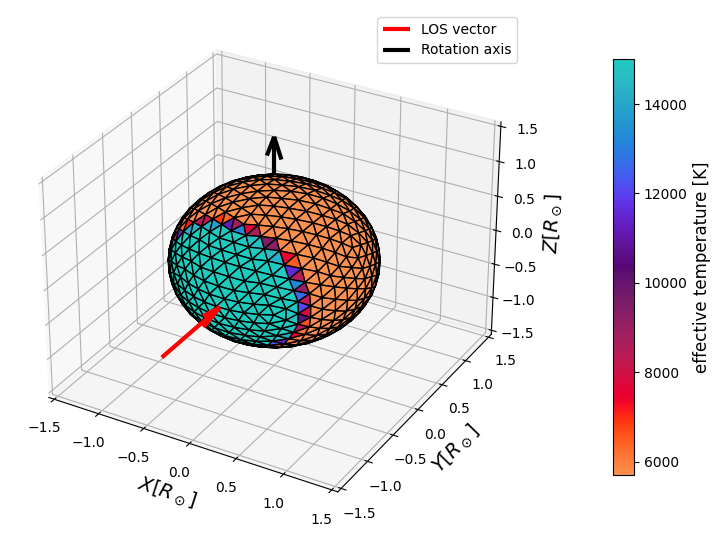

In [5]:
_, _ = plot_3D(mts[50], 0, cmap='cmr.guppy', property_label='effective temperature [K]')

# Tilted rotation

To add a tilted rotation (with respect to the LOS), a different ```rotation_axis``` can be passed. The vector is going to be normalized to a unit length of one.

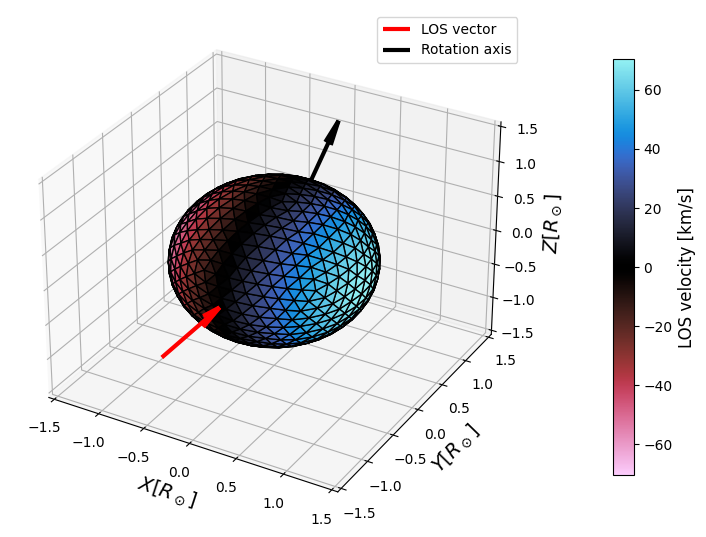

In [6]:
mt_tilted = add_rotation(m, 100, rotation_axis=jnp.array([0., 1., 1.]))
mts_tilted = [evaluate_rotation(mt_tilted, t) for t in TIMESTAMPS]

_, _ = plot_3D(mts_tilted[35], 'los_velocities')

## Spectrum emulation

Now we can simulate the spectrum at the default distance of $d=10$ pc.

In [7]:
from tqdm import tqdm

vws = jnp.linspace(100., 12000., 100)
specs = [simulate_observed_flux(bb.intensity, _mt, jnp.log10(vws)) for _mt in tqdm(mts)]

100%|██████████| 100/100 [00:01<00:00, 52.93it/s]


Let's plot the subset to see the change of the line more clearly.

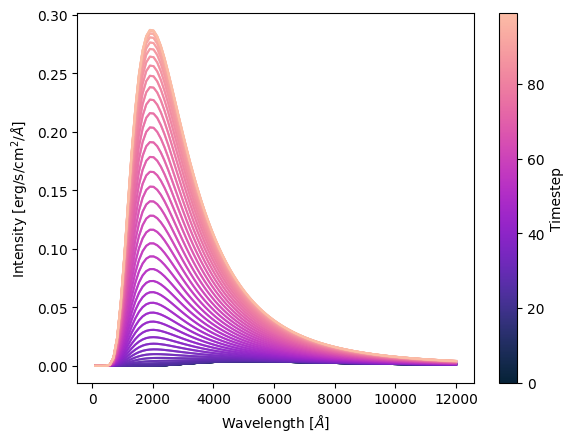

In [15]:
_, ax = plt.subplots()
cmap = cmr.bubblegum
colors = cmap(np.linspace(0, 1, len(specs[:50])))

# Plot the spectra with colors based on timesteps
for i, spec in enumerate(specs[:50]):
    plt.plot(vws, spec, color=colors[i], alpha=0.8)

# Add a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=len(specs)-1))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Timestep')

ax.set_xlabel('Wavelength [$\AA$]')
ax.set_ylabel('Intensity [erg/s/cm$^2$/$\AA$]');

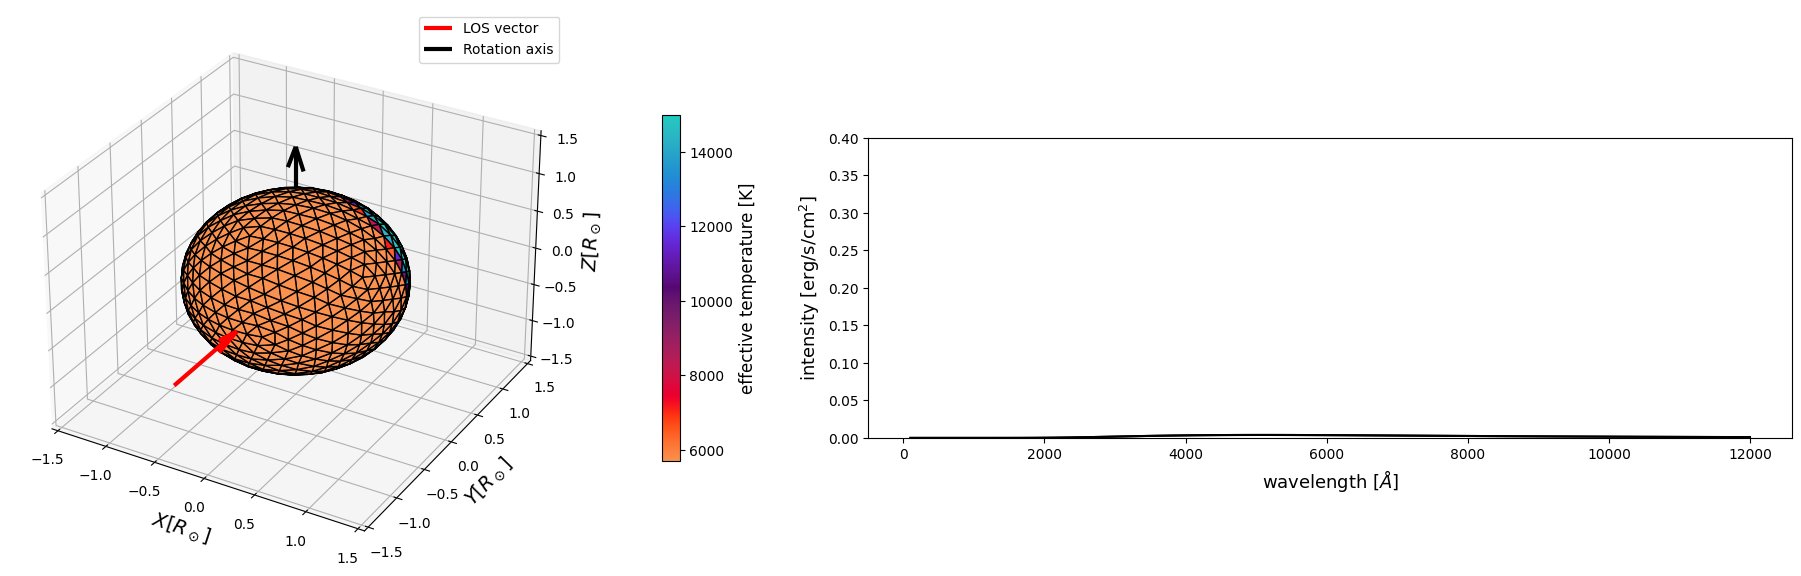

In [9]:
time_idx = 5
_, spectrum_ax = plot_3D_mesh_and_spectrum(mts[time_idx], vws, specs[time_idx], dict(property=0, cmap='cmr.guppy', property_label='effective temperature [K]'));
spectrum_ax.set_ylim(0, 0.4);

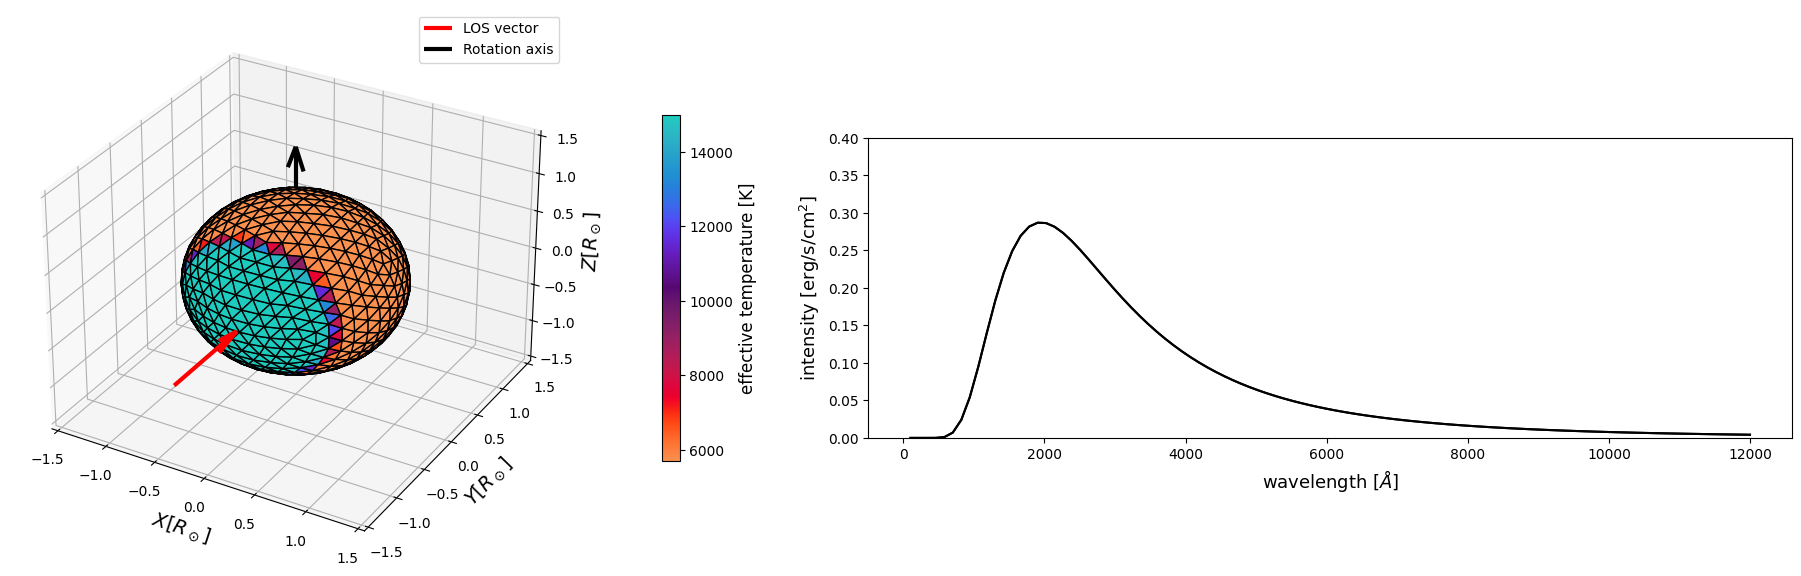

In [10]:
time_idx = 49
_, spectrum_ax = plot_3D_mesh_and_spectrum(mts[time_idx], vws, specs[time_idx], dict(property=0, cmap='cmr.guppy', property_label='effective temperature [K]'));
spectrum_ax.set_ylim(0, 0.4);


## Photometric time series

In [11]:
from spice.spectrum.filter import BesselU, BesselB, BesselV
from spice.spectrum.spectrum import AB_passband_luminosity

In [12]:
bessel_B = BesselB()
bessel_U = BesselU()
bessel_V = BesselV()

In [13]:
d = u.AU.to(u.cm)
U_phot = np.array([AB_passband_luminosity(bessel_U, vws, flux[:, 0]) for flux in specs])
B_phot = np.array([AB_passband_luminosity(bessel_B, vws, flux[:, 0]) for flux in specs])
V_phot = np.array([AB_passband_luminosity(bessel_V, vws, flux[:, 0]) for flux in specs])

# Calculate color indices
U_B = U_phot - B_phot
B_V = B_phot - V_phot


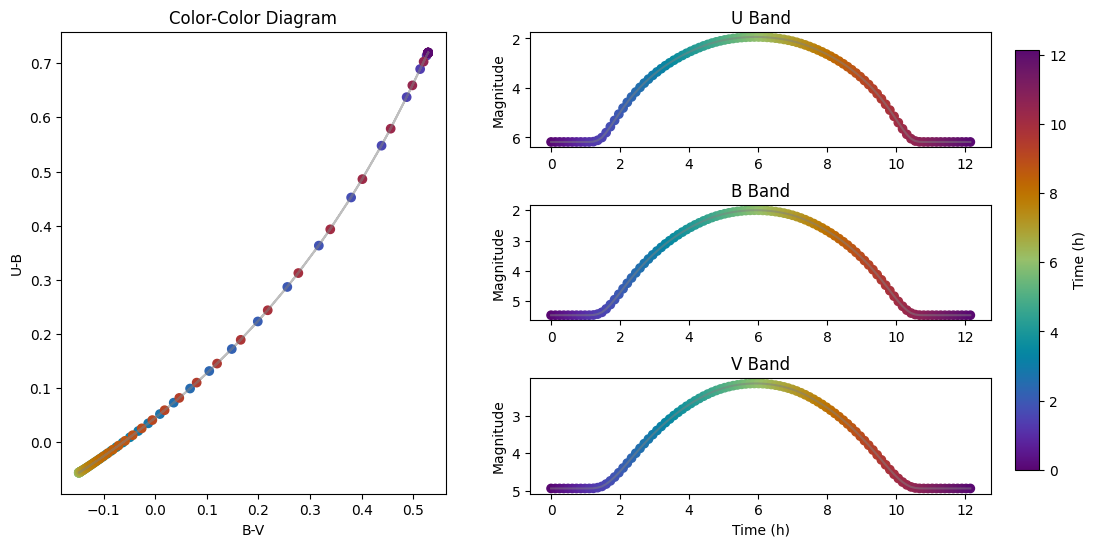

In [14]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(3, 2, width_ratios=[1, 1.2], figure=fig)

# Plot color-color diagram
ax_color = fig.add_subplot(gs[:, 0])
ax_color.plot(B_V, U_B, alpha=0.5, color='gray')
scatter = ax_color.scatter(B_V, U_B, c=TIMESTAMPS/3600, cmap='cmr.infinity')
ax_color.set_xlabel('B-V')
ax_color.set_ylabel('U-B')
ax_color.set_title('Color-Color Diagram')

# Photometry data and labels for loop
phot_data = [U_phot, B_phot, V_phot]
labels = ['U Band', 'B Band', 'V Band']

# Create photometry magnitude time series plots
axes = []
for i, (data, label) in enumerate(zip(phot_data, labels)):
    ax = fig.add_subplot(gs[i, 1], sharex=axes[0] if axes else None)
    axes.append(ax)
    ax.plot(TIMESTAMPS/3600, data, alpha=0.5, color='gray')
    ax.scatter(TIMESTAMPS/3600, data, c=TIMESTAMPS/3600, cmap='cmr.infinity')
    
    ax.set_title(label)
    if i == len(phot_data)-1:  # Only show xlabel on bottom subplot
        ax.set_xlabel('Time (h)')
    ax.set_ylabel('Magnitude')
    plt.subplots_adjust(hspace=0.5)
    ax.invert_yaxis()

# Add colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(scatter, cax=cbar_ax, label='Time (h)')